## Dependencies

In [45]:
import pandas
%pip install pandas
%pip install fastparquet
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install keras
%pip install pydot
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Setup

In [66]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from wandb.keras import WandbCallback

## Import and preprocess data

In [47]:
df = pd.read_parquet("data/Thermo_SRM_Pool_meta_data.parquet", engine='fastparquet')

In [48]:
print(df.shape)
print(df.head(4))
print(df.columns)

(6080606, 15)
                                       raw_file  scan_number  \
0  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        34736   
1  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        25591   
2  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        24831   
3  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        34870   

      modified_sequence  precursor_charge  precursor_intensity          mz  \
0  LPGSLETYVEQEQGENANDR                 2           29525630.0  1125.01950   
1       HGSLQEYLQNDTGSK                 2           13188580.0   838.89737   
2        VEEEEEINSELTAR                 2           20663460.0   824.38904   
3  LPGSLETYVEQEQGENANDR                 2           19884630.0  1125.01950   

   precursor_mz fragmentation mass_analyzer  retention_time  \
0   1125.018331           CID          ITMS          38.411   
1    838.894401           HCD          FTMS          30.394   
2    824.388401           CID          ITMS          29.737   
3   1125.018831       

### Check what charge states are in the data

In [49]:
list_charge = df["precursor_charge"].unique().tolist()
print(sorted(list_charge))

[1, 2, 3, 4, 5, 6, 7]


### Create dataframe containing only sequence and precursor charge

In [50]:
# drop all columns we don't need for training
for column in df.columns:
    if column not in ["modified_sequence", "precursor_charge"]:
        df.drop(column, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080606 entries, 0 to 6080605
Data columns (total 2 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   modified_sequence  object
 1   precursor_charge   int64 
dtypes: int64(1), object(1)
memory usage: 92.8+ MB


### Remove all sequences containing '[UNIMOD:'

In [51]:
def delete_entries_with_partial_string(dataframe, column_name, partial_string):
    escaped_string = re.escape(partial_string)
    dataframe = dataframe[~dataframe[column_name].str.contains(escaped_string)]
    return dataframe

In [52]:
df_filtered = delete_entries_with_partial_string(df, 'modified_sequence', '[UNIMOD:')
df_filtered

,modified_sequence,precursor_charge
0,LPGSLETYVEQEQGENANDR,2
1,HGSLQEYLQNDTGSK,2
2,VEEEEEINSELTAR,2
3,LPGSLETYVEQEQGENANDR,2
4,NSSTAEINETTTSSTDFLAR,2
...,...,...
6080594,HGIGSLLLESLK,3
6080599,ALEAENSALALENENQR,2
6080600,ALEAENSALALENENQR,2
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3


### Convert protein sequences to numerical representation

In [53]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')  # List of amino acids

def sequence_to_vector(sequence):
    vector = []
    for amino_acid in sequence:
        if amino_acid in amino_acids:
            vector.append(amino_acids.index(amino_acid))
        else:
            vector.append(len(amino_acids))  # Handle unknown amino acids
    return vector

df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)
df_filtered

C:\Users\Florian\AppData\Local\Temp\ipykernel_14192\2493357873.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)


,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14]"
3,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...
6080594,HGIGSLLLESLK,3,"[6, 5, 7, 5, 15, 9, 9, 9, 3, 15, 9, 8]"
6080599,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080600,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


### Pad sequence_vectors to the max sequence length

In [54]:
def pad_sequences(dataframe, column_name, pad_value=21):
    max_len = max(dataframe.loc[:, column_name].apply(len))  # Find the maximum length
    dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: x + [pad_value] * (max_len - len(x)))  # Pad the sequences
    return max_len, dataframe

In [55]:
max_len, df_filtered_padded = pad_sequences(df_filtered, 'sequence_vector')

C:\Users\Florian\AppData\Local\Temp\ipykernel_14192\3258746580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: x + [pad_value] * (max_len - len(x)))  # Pad the sequences


In [56]:
df_filtered_padded

,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14..."
3,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...
6080594,HGIGSLLLESLK,3,"[6, 5, 7, 5, 15, 9, 9, 9, 3, 15, 9, 8, 21, 21,..."
6080599,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080600,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


### Calculate weights to correct for class imbalance
- Count occurrences for each charge state in the dataset
- Calculate bias for binary prediction
    - class with only precursor charge 2
    - class with every other precursor charge

In [57]:
df_SingleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 1].copy()
df_DoubleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 2].copy()
df_TripleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 3].copy()
df_QuadrupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 4].copy()
df_QuintupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 5].copy()
df_SextupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 6].copy()
df_SeptupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 7].copy()
# other charges than 2
df_OtherCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] != 2].copy()

In [58]:
CLASS_NAMES = ["DoubleCharge", "OtherCharges"]

In [59]:
COUNT_SingleCharges = len(df_SingleCharges)
COUNT_DoubleCharges = len(df_DoubleCharges)
COUNT_TripleCharges = len(df_TripleCharges)
COUNT_QuadrupleCharges = len(df_QuadrupleCharges)
COUNT_QuintupleCharges = len(df_QuintupleCharges)
COUNT_SextupleCharges = len(df_SingleCharges)
COUNT_SeptupleCharges = len(df_SeptupleCharges)
COUNT_OtherCharges = len(df_OtherCharges)

print("COUNT_SingleCharge: {}".format(COUNT_SingleCharges))
print("COUNT_DoubleCharge: {}".format(COUNT_DoubleCharges))
print("COUNT_TripleCharges:  {}".format(COUNT_TripleCharges))
print("COUNT_QuadrupleCharges: {}".format(COUNT_QuadrupleCharges))
print("COUNT_QuintupleCharges: {}".format(COUNT_QuintupleCharges))
print("COUNT_SextupleCharges: {}".format(COUNT_SextupleCharges))
print("COUNT_SeptupleCharges: {}".format(COUNT_SeptupleCharges))

COUNT_SingleCharge: 999
COUNT_DoubleCharge: 3486981
COUNT_TripleCharges:  1185177
COUNT_QuadrupleCharges: 86471
COUNT_QuintupleCharges: 1694
COUNT_SextupleCharges: 999
COUNT_SeptupleCharges: 1


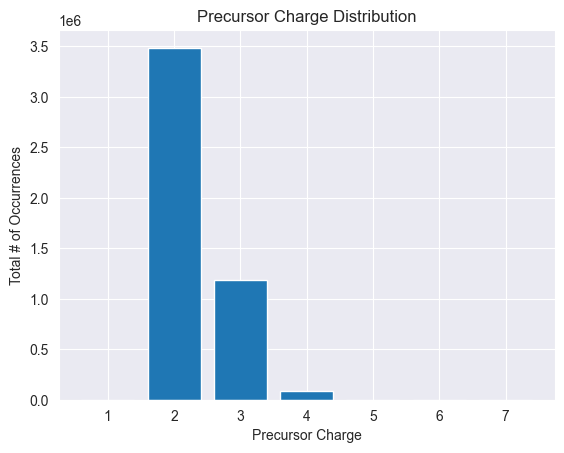

In [60]:
charge_counts = [COUNT_SingleCharges, COUNT_DoubleCharges, COUNT_TripleCharges, COUNT_QuadrupleCharges, COUNT_QuintupleCharges, COUNT_SextupleCharges, COUNT_SeptupleCharges]
charge_labels = ['1', '2', '3', '4', '5', '6', '7']
plt.bar(charge_labels, charge_counts)
plt.title('Precursor Charge Distribution')
plt.xlabel('Precursor Charge')
plt.ylabel('Total # of Occurrences')
plt.show()

In [61]:
initial_bias = np.log([COUNT_DoubleCharges / COUNT_OtherCharges])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAINING_COUNT = COUNT_DoubleCharges + COUNT_OtherCharges
weight_for_other = (1 / COUNT_OtherCharges) * TRAINING_COUNT / 2.0
weight_for_double = (1 / COUNT_DoubleCharges) * TRAINING_COUNT / 2.0

print("weight for Double Charge: {:.2f}".format(weight_for_double))
print("weight for Other Charges: {:.2f}".format(weight_for_other))

Initial bias: 1.00652
weight for Double Charge: 0.68
weight for Other Charges: 1.87


In [62]:
# Initialize Weights and Biases
# wandb.init(project='precursor_charge_prediction')

In [69]:
# Split the data into train, validation, and test sets
X = np.array(df_filtered_padded['sequence_vector'].tolist())
y = np.array(df_filtered_padded['precursor_charge'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # splits X/y_train_val in X/y_train and X/y_val

### Stratified split won't work as there is only one entry for the Septuple_charges
"""
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_val_indices, test_indices = next(sss.split(X, y))
X_train_val, X_test = X[train_val_indices], X[test_indices]
y_train_val, y_test = y[train_val_indices], y[test_indices]

# Create another instance of StratifiedShuffleSplit for train-validation split
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the train-validation split
train_indices, val_indices = next(sss_train_val.split(X_train_val, y_train_val))
X_train, X_val = X_train_val[train_indices], X_train_val[val_indices]
y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]
"""

# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_len, output_dim=7, input_length=X.shape[1]), # original input dim 22, output dim 16 ## max_len-1 ??
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
# Configure Weights and Biases callback
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/best_model_sparse_cce.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# wandb_callback = WandbCallback()

In [71]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [72]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback, early_stopping]) #, wandb_callback])

Epoch 1/10
95229/95229 [==============================] - 158s 2ms/step - loss: 0.2980 - accuracy: 0.8608 - val_loss: 0.2829 - val_accuracy: 0.8666
Epoch 2/10
95229/95229 [==============================] - 148s 2ms/step - loss: 0.2812 - accuracy: 0.8678 - val_loss: 0.2759 - val_accuracy: 0.8705
Epoch 3/10
95229/95229 [==============================] - 148s 2ms/step - loss: 0.2769 - accuracy: 0.8697 - val_loss: 0.2770 - val_accuracy: 0.8689
Epoch 4/10
95229/95229 [==============================] - 154s 2ms/step - loss: 0.2746 - accuracy: 0.8707 - val_loss: 0.2740 - val_accuracy: 0.8709
Epoch 5/10
95229/95229 [==============================] - 154s 2ms/step - loss: 0.2731 - accuracy: 0.8714 - val_loss: 0.2729 - val_accuracy: 0.8710
Epoch 6/10
95229/95229 [==============================] - 156s 2ms/step - loss: 0.2721 - accuracy: 0.8718 - val_loss: 0.2731 - val_accuracy: 0.8719
Epoch 7/10
95229/95229 [==============================] - 148s 2ms/step - loss: 0.2715 - accuracy: 0.8719 - val_

In [75]:
# Access the loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

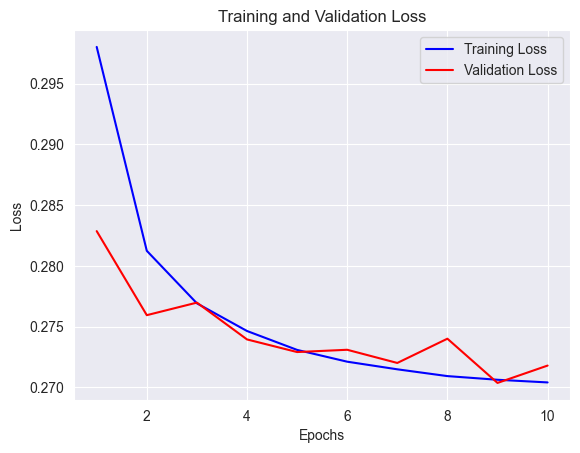

In [76]:
# Plot the loss and validation loss curves
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

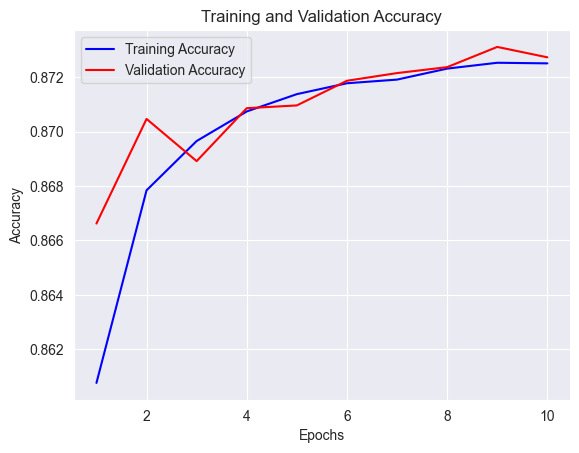

In [79]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [77]:
# Load the best model
best_model = tf.keras.models.load_model('precursor_charge_prediction_model_v1/best_model.h5')

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

# Save the best model to Weights and Biases
# wandb.save('best_model.h5')

29759/29759 [==============================] - 32s 1ms/step - loss: 0.2620 - accuracy: 0.8751
Accuracy: 0.8750681281089783


In [78]:
best_model.save('precursor_charge_prediction_model_v1')

INFO:tensorflow:Assets written to: precursor_charge_prediction_model_v1\assets


INFO:tensorflow:Assets written to: precursor_charge_prediction_model_v1\assets


### Adding class weights

In [ ]:
# Calculate class weights
class_labels = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
# Convert class weights to dictionary
class_weights_dict = dict(zip(class_labels, class_weights))
print(class_weights_dict)

In [25]:
checkpoint_callback_classweights = ModelCheckpoint('precursor_charge_prediction_model_v1/best_model_classweights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [26]:
# Train the model with class-weights
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint_callback_classweights], class_weight=class_weights_dict) #, wandb_callback])

ValueError: Expected `class_weight` to be a dict with keys from 0 to one less than the number of classes, found {1: 669.3278861360042, 2: 0.1951470232630578, 3: 0.5731530811184621, 4: 7.882430237250256, 5: 416.02719528178244, 6: 6254.753694581281, 7: 544163.5714285715}

### Trying hyperparameter optimization

## Evaluate the models
- confusion matrix
- accuracy
- loss

## Testing the model
- Generate some random sequences
- run them through the model

In [ ]:
# Generate random peptide sequences
num_sequences = 10  # Number of sequences to generate
max_length = 20  # Maximum sequence length
sequences = []
for _ in range(num_sequences):
    length = random.randint(1, max_length)
    sequence = ''.join(random.choices(amino_acids, k=length))
    sequences.append(sequence)

In [42]:
# Convert peptide sequences to numerical representation
def sequence_to_vector(sequence):
    vector = []
    for amino_acid in sequence:
        if amino_acid in amino_acids:
            vector.append(amino_acids.index(amino_acid))
        else:
            vector.append(len(amino_acids))  # Handle unknown amino acids
    return np.array(vector)

# Convert the generated sequences to numerical representation
sequence_vectors = np.array([sequence_to_vector(seq) for seq in sequences])

# Load the trained model
model = tf.keras.models.load_model('precursor_charge_prediction_model_v1')  # Replace with the path to your trained model

# Predict precursor charge for the generated sequences
predictions = model.predict(sequence_vectors)
predicted_charge = np.argmax(predictions, axis=1) + 1

# Display the generated sequences and predicted precursor charge
for sequence, charge in zip(sequences, predicted_charge):
    print('Sequence:', sequence)
    print('Predicted Charge:', charge)
    print('-------------------')